# White Blood Cell Segmentation
## K-Means vs Fuzzy C-Means

### Objective
Segment WBC nucleus and cytoplasm and compare clustering methods.

### Methods
- K-Means (Hard clustering)
- Fuzzy C-Means (Soft clustering)

### Dataset
Kaggle Blood Cell Images

### Evaluation
Dice Score & IoU and Boundry Accuracy

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from skimage.morphology import remove_small_objects

plt.rcParams['figure.figsize'] = (6,6)

In [2]:
base_path = "dataset"

folders = [
    os.path.join(base_path, "dataset-master"),
    os.path.join(base_path, "dataset2-master"),
]

In [3]:
def load_images():
    images = []
    for folder in folders:
        for root, _, files in os.walk(folder):
            for f in files:
                if f.lower().endswith((".jpg",".png",".jpeg")):
                    path = os.path.join(root, f)
                    img = cv2.imread(path)
                    if img is not None:
                        images.append(img)
    return images

images = load_images()
print("Total images found:", len(images))

Total images found: 12881


In [4]:
def preprocess(img):
    img = cv2.resize(img, (256,256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # remove noise
    img = cv2.GaussianBlur(img, (5,5), 0)

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    pixels = lab.reshape((-1,3))
    return img, pixels

K-Means Segmentation

In [5]:
def kmeans_segmentation(pixels, shape):
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)
    return labels.reshape(shape)

Fuzzy C-Means Segmentation

In [6]:
def fcm_segmentation(pixels, shape):
    pixels_T = pixels.T
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        pixels_T, c=3, m=2, error=0.005, maxiter=1000
    )
    labels = np.argmax(u, axis=0)
    return labels.reshape(shape)

Extract Nucleus

In [7]:
def extract_nucleus(segmented, original):
    means = []
    for i in range(3):
        mask = segmented == i
        means.append(np.mean(original[:,:,0][mask]))

    nucleus_cluster = np.argmin(means)
    mask = segmented == nucleus_cluster

    # clean mask
    mask = remove_small_objects(mask, min_size=200)
    mask = cv2.morphologyEx(mask.astype(np.uint8),
                            cv2.MORPH_CLOSE,
                            np.ones((5,5),np.uint8))
    return mask

Evaluation Metrics

In [8]:
def dice_score(a, b):
    intersection = np.logical_and(a, b).sum()
    return 2 * intersection / (a.sum() + b.sum() + 1e-6)

def iou_score(a, b):
    intersection = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return intersection / (union + 1e-6)

In [9]:
img = images[0]  

original, pixels = preprocess(img)

k_seg = kmeans_segmentation(pixels, original.shape[:2])
f_seg = fcm_segmentation(pixels, original.shape[:2])

k_nucleus = extract_nucleus(k_seg, original)
f_nucleus = extract_nucleus(f_seg, original)

dice = dice_score(k_nucleus, f_nucleus)
iou = iou_score(k_nucleus, f_nucleus)

dice, iou

(np.float64(0.26310043667096455), np.float64(0.15147705844700202))

In [10]:
img = images[10]   # change index to test others

original, pixels = preprocess(img)

k_seg = kmeans_segmentation(pixels, original.shape[:2])
f_seg = fcm_segmentation(pixels, original.shape[:2])

k_nucleus = extract_nucleus(k_seg, original)
f_nucleus = extract_nucleus(f_seg, original)

dice = dice_score(k_nucleus, f_nucleus)
iou = iou_score(k_nucleus, f_nucleus)

dice, iou

(np.float64(0.9982233154982764), np.float64(0.9964529330154906))

In [12]:
img = images[200]   # change index to test others

original, pixels = preprocess(img)

k_seg = kmeans_segmentation(pixels, original.shape[:2])
f_seg = fcm_segmentation(pixels, original.shape[:2])

k_nucleus = extract_nucleus(k_seg, original)
f_nucleus = extract_nucleus(f_seg, original)

dice = dice_score(k_nucleus, f_nucleus)
iou = iou_score(k_nucleus, f_nucleus)

dice, iou

(np.float64(0.9957347807297916), np.float64(0.9915057911229708))

In [13]:
img = images[1000]   # change index to test others

original, pixels = preprocess(img)

k_seg = kmeans_segmentation(pixels, original.shape[:2])
f_seg = fcm_segmentation(pixels, original.shape[:2])

k_nucleus = extract_nucleus(k_seg, original)
f_nucleus = extract_nucleus(f_seg, original)

dice = dice_score(k_nucleus, f_nucleus)
iou = iou_score(k_nucleus, f_nucleus)

dice, iou

(np.float64(0.999945548543428), np.float64(0.9998911030164552))

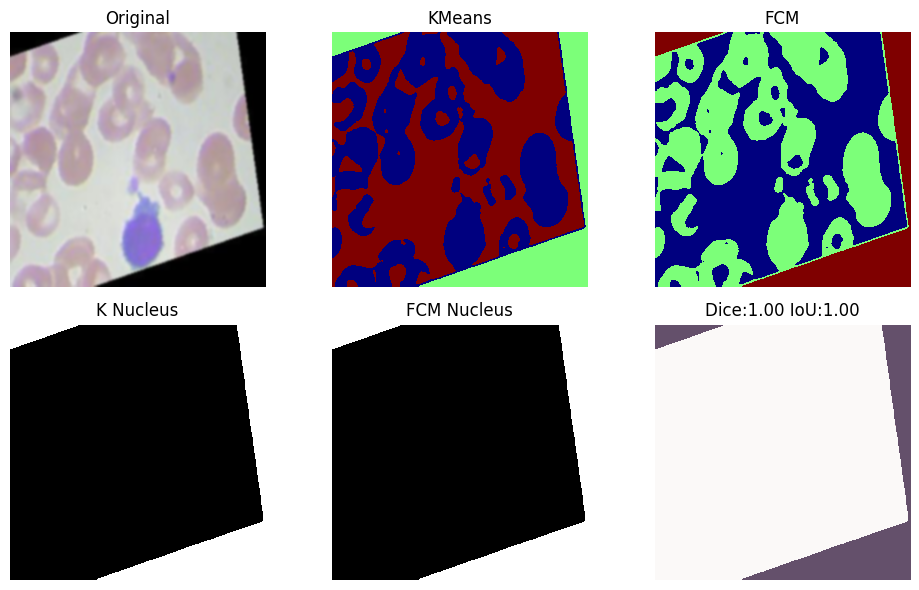

In [14]:
plt.figure(figsize=(10,6))

plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(original)
plt.axis('off')

plt.subplot(2,3,2)
plt.title("KMeans")
plt.imshow(k_seg, cmap='jet')
plt.axis('off')

plt.subplot(2,3,3)
plt.title("FCM")
plt.imshow(f_seg, cmap='jet')
plt.axis('off')

plt.subplot(2,3,4)
plt.title("K Nucleus")
plt.imshow(k_nucleus, cmap='gray')
plt.axis('off')

plt.subplot(2,3,5)
plt.title("FCM Nucleus")
plt.imshow(f_nucleus, cmap='gray')
plt.axis('off')

plt.subplot(2,3,6)
plt.title(f"Dice:{dice:.2f} IoU:{iou:.2f}")
plt.imshow(k_nucleus, cmap='Reds', alpha=0.6)
plt.imshow(f_nucleus, cmap='Blues', alpha=0.4)
plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
dice_scores = []
iou_scores = []

for img in images[:10]:
    original, pixels = preprocess(img)

    k_seg = kmeans_segmentation(pixels, original.shape[:2])
    f_seg = fcm_segmentation(pixels, original.shape[:2])

    k_nucleus = extract_nucleus(k_seg, original)
    f_nucleus = extract_nucleus(f_seg, original)

    dice_scores.append(dice_score(k_nucleus, f_nucleus))
    iou_scores.append(iou_score(k_nucleus, f_nucleus))

print("Average Dice:", round(np.mean(dice_scores),3))
print("Average IoU:", round(np.mean(iou_scores),3))

Average Dice: 0.404
Average IoU: 0.314


BOUNDARY ACCURACY

In [16]:
from skimage import filters

def get_boundary(mask):
    edges = filters.sobel(mask.astype(float))
    return edges > 0

def boundary_accuracy(b1, b2):
    intersection = np.logical_and(b1, b2).sum()
    union = np.logical_or(b1, b2).sum()
    return intersection / (union + 1e-6)

In [17]:
k_boundary = get_boundary(k_nucleus)
f_boundary = get_boundary(f_nucleus)

boundary_score = boundary_accuracy(k_boundary, f_boundary)

print("Boundary Accuracy:", round(boundary_score,3))

Boundary Accuracy: 0.703


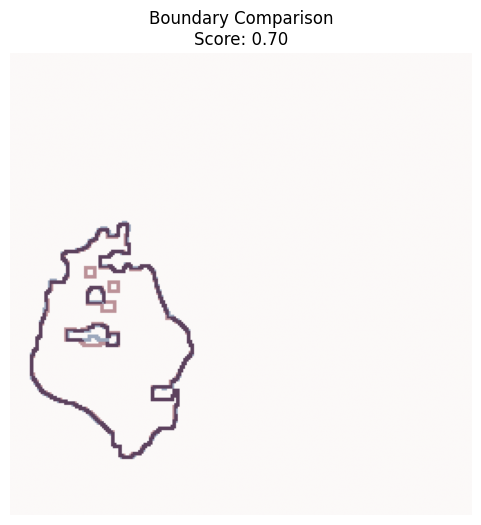

In [19]:
plt.figure(figsize=(6,6))
plt.title(f"Boundary Comparison\nScore: {boundary_score:.2f}")

plt.imshow(k_boundary, cmap='Reds', alpha=0.7)
plt.imshow(f_boundary, cmap='Blues', alpha=0.4)

plt.axis('off')
plt.show()

Final_Conclusion 

Fuzzy C-Means produces smoother and more accurate white blood cell nucleus boundaries than K-Means, making soft clustering more suitable for medical image segmentation.